In [1]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.express as px
%matplotlib inline

import time

# Dimension reduction and clustering libraries
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, accuracy_score, precision_score, recall_score
from tensorflow.keras import Model, Input, layers, losses, optimizers, datasets
from bokeh.plotting import figure, show, output_notebook, gridplot,ColumnDataSource
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf


import dynamo as dyn
import anndata as ad
import pandas as pd

In [2]:

df = pd.read_csv("../data/dataset.csv")

df

Station_id           IODateTime        DataType  Value
0         CM-LS-114  2014-01-01 00:00:00     Temperature   15.3
1         CM-LS-114  2014-01-01 00:05:00     Temperature   15.4
2         CM-LS-114  2014-01-01 00:10:00     Temperature   15.4
3         CM-LS-114  2014-01-01 00:15:00     Temperature   15.4
4         CM-LS-114  2014-01-01 00:20:00     Temperature   15.1
...             ...                  ...             ...    ...
19584656  CM-LS-241  2019-12-27 13:40:00  BatteryVoltage   13.5
19584657  CM-LS-241  2019-12-27 13:45:00  BatteryVoltage   13.5
19584658  CM-LS-241  2019-12-27 13:50:00  BatteryVoltage   13.5
19584659  CM-LS-241  2019-12-27 13:55:00  BatteryVoltage   13.5
19584660  CM-LS-241  2019-12-27 14:00:00  BatteryVoltage   13.6

[19584661 rows x 4 columns]

In [3]:
# df = df.drop(columns=['SignalQuality'])
df = df[df['DataType'] != 'SignalQuality']
df

Station_id           IODateTime        DataType  Value
0         CM-LS-114  2014-01-01 00:00:00     Temperature   15.3
1         CM-LS-114  2014-01-01 00:05:00     Temperature   15.4
2         CM-LS-114  2014-01-01 00:10:00     Temperature   15.4
3         CM-LS-114  2014-01-01 00:15:00     Temperature   15.4
4         CM-LS-114  2014-01-01 00:20:00     Temperature   15.1
...             ...                  ...             ...    ...
19584656  CM-LS-241  2019-12-27 13:40:00  BatteryVoltage   13.5
19584657  CM-LS-241  2019-12-27 13:45:00  BatteryVoltage   13.5
19584658  CM-LS-241  2019-12-27 13:50:00  BatteryVoltage   13.5
19584659  CM-LS-241  2019-12-27 13:55:00  BatteryVoltage   13.5
19584660  CM-LS-241  2019-12-27 14:00:00  BatteryVoltage   13.6

[15667556 rows x 4 columns]

In [4]:
df_cleansing = df.pivot(index=['IODateTime', 'Station_id'], columns='DataType', values='Value').reset_index()
df_cleansing = df_cleansing.dropna()
df_cleansing

DataType           IODateTime Station_id  BatteryVoltage  Humidity  Rain  \
0         2014-01-01 00:00:00  CM-LS-002            12.8      87.2   0.2   
1         2014-01-01 00:00:00  CM-LS-010            13.0      74.4   0.2   
2         2014-01-01 00:00:00  CM-LS-029            10.6       0.1   0.4   
3         2014-01-01 00:00:00  CM-LS-032            13.1      51.6   0.0   
4         2014-01-01 00:00:00  CM-LS-037            12.8      93.8   0.0   
...                       ...        ...             ...       ...   ...   
3917100   2019-12-27 13:55:00  CM-LS-125            13.5      56.4   0.0   
3917101   2019-12-27 13:55:00  CM-LS-177            13.5      55.6   0.0   
3917102   2019-12-27 13:55:00  CM-LS-241            13.5      59.7   0.0   
3917103   2019-12-27 14:00:00  CM-LS-018            13.5      47.6   0.0   
3917104   2019-12-27 14:00:00  CM-LS-241            13.6      59.9   0.0   

DataType  Temperature  
0                15.5  
1                14.2  
2                14.9  
3                15.2  
4                15.8  
...               ...  
3917100          30.1  
3917101          28.8  
3917102          27.5  
3917103          28.3  
3917104          27.6  

[3916241 rows x 6 columns]

In [5]:
df_cleansing['IODateTime'] = pd.to_datetime(df_cleansing['IODateTime'],format='%Y-%m-%d %H:%M:%S')

In [6]:
df_cleansing = df_cleansing.groupby(['Station_id', pd.Grouper(key='IODateTime', freq='H')]).agg(BatteryVoltage=('BatteryVoltage', 'mean'), Humidity=('Humidity', 'mean'), Rain=('Rain', 'sum'), Temperature=('Temperature', 'mean')).reset_index()

In [7]:
df_cleansing.columns = ['Station_id', 'IODateTime', 'Value_BatteryVoltage', 'Value_Humidity', 'Value_Rain', 'Value_Temperature']
df_cleansing = df_cleansing [['IODateTime', 'Station_id', 'Value_BatteryVoltage', 'Value_Humidity', 'Value_Rain', 'Value_Temperature']]
df_cleansing

IODateTime Station_id  Value_BatteryVoltage  Value_Humidity  \
0      2014-01-01 00:00:00  CM-LS-002             12.800000       87.200000   
1      2014-01-01 01:00:00  CM-LS-002             12.800000       87.200000   
2      2014-01-01 02:00:00  CM-LS-002             12.800000       87.250000   
3      2014-01-01 03:00:00  CM-LS-002             12.800000       87.391667   
4      2014-01-01 04:00:00  CM-LS-002             12.733333       87.441667   
...                    ...        ...                   ...             ...   
326494 2019-12-27 10:00:00  CM-LS-241             13.500000       84.108333   
326495 2019-12-27 11:00:00  CM-LS-241             13.516667       76.466667   
326496 2019-12-27 12:00:00  CM-LS-241             13.491667       64.700000   
326497 2019-12-27 13:00:00  CM-LS-241             13.491667       58.908333   
326498 2019-12-27 14:00:00  CM-LS-241             13.600000       59.900000   

        Value_Rain  Value_Temperature  
0              0.2          15.475000  
1              2.0          15.283333  
2              2.4          14.600000  
3              2.4          13.750000  
4              2.4          13.800000  
...            ...                ...  
326494         0.0          19.950000  
326495         0.0          22.366667  
326496         0.0          25.325000  
326497         0.0          27.375000  
326498         0.0          27.600000  

[326499 rows x 6 columns]

In [8]:
df_c = pd.wide_to_long(df_cleansing, stubnames='Value', i=['IODateTime', 'Station_id'], j='DataType', sep='_', suffix=r'\w+').reset_index()

In [9]:
df = df_c.sort_values(by=['DataType','Station_id', 'IODateTime']).reset_index()

In [10]:
df['IODateTime'] = pd.to_datetime(df['IODateTime'],format='%Y-%m-%d %H:%M:%S')
df["h"] = df.IODateTime.dt.hour
df["d"] = df.IODateTime.dt.date
df["doy"] = df.IODateTime.dt.dayofyear
df["year"] = df.IODateTime.dt.year

In [11]:
df

index          IODateTime Station_id        DataType      Value  \
0              0 2014-01-01 00:00:00  CM-LS-002  BatteryVoltage  12.800000   
1              4 2014-01-01 01:00:00  CM-LS-002  BatteryVoltage  12.800000   
2              8 2014-01-01 02:00:00  CM-LS-002  BatteryVoltage  12.800000   
3             12 2014-01-01 03:00:00  CM-LS-002  BatteryVoltage  12.800000   
4             16 2014-01-01 04:00:00  CM-LS-002  BatteryVoltage  12.733333   
...          ...                 ...        ...             ...        ...   
1305991  1305979 2019-12-27 10:00:00  CM-LS-241     Temperature  19.950000   
1305992  1305983 2019-12-27 11:00:00  CM-LS-241     Temperature  22.366667   
1305993  1305987 2019-12-27 12:00:00  CM-LS-241     Temperature  25.325000   
1305994  1305991 2019-12-27 13:00:00  CM-LS-241     Temperature  27.375000   
1305995  1305995 2019-12-27 14:00:00  CM-LS-241     Temperature  27.600000   

          h           d  doy  year  
0         0  2014-01-01    1  2014  
1         1  2014-01-01    1  2014  
2         2  2014-01-01    1  2014  
3         3  2014-01-01    1  2014  
4         4  2014-01-01    1  2014  
...      ..         ...  ...   ...  
1305991  10  2019-12-27  361  2019  
1305992  11  2019-12-27  361  2019  
1305993  12  2019-12-27  361  2019  
1305994  13  2019-12-27  361  2019  
1305995  14  2019-12-27  361  2019  

[1305996 rows x 9 columns]

In [12]:
print(len(df[df.year == 2019]))
print(len(df[df.year == 2019]['Station_id'].unique()))

172800
5


<AxesSubplot:xlabel='IODateTime'>

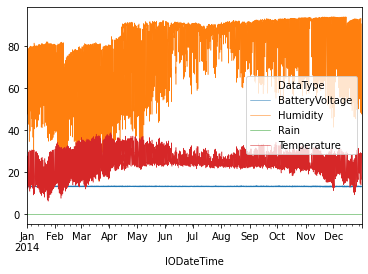

In [14]:
timeline = df[df.Station_id == "CM-LS-032"][["IODateTime", "Value", "DataType"]]
timeline = timeline.pivot(index='IODateTime', columns='DataType', values='Value')
timeline.plot(lw=0.5)

In [13]:
def errCount(_df, dt):
    if dt == "Temperature":
        return np.where((_df < -10) | (_df > 60), 1, 0).sum(axis=1)
    elif dt == "Humidity":
        return np.where((_df < 1) | (_df > 100), 1, 0).sum(axis=1)
    elif dt == "Rain":
        return np.where((_df < 0) | (_df > 100), 1, 0).sum(axis=1)
    elif dt == "BatteryVoltage":
        return np.where((_df < 12) | (_df > 15), 1, 0).sum(axis=1)
    else: return [] 


In [14]:
result = pd.DataFrame()
df_X = pd.DataFrame()

dub_station = df[~df[["Station_id", "year"]].duplicated()].reset_index(drop=True)

for dtype in df.DataType.unique():
    Xdata = []
    stns = []
    for i, row in dub_station.iterrows():
        print(row.Station_id, "-", dtype)
        X = df[(df.DataType == dtype) & (df.Station_id == row.Station_id) & (df.year == row.year)].pivot(index='d', columns='h', values='Value').reset_index()
        Xdata.append(X)
        stns = stns + [row.Station_id for x in range(len(X))]

    Xdata = pd.concat(Xdata).reset_index()
    result['station'] = stns
    # result['time'] = Xdata['doy']
    result['DateTime'] = Xdata['d']
    
    Xdata = Xdata.drop(columns=['d', 'index'])  
    Xdata.columns  = dtype+"_"+Xdata.columns.astype(str)

    df_X = pd.concat([df_X, Xdata], axis=1, sort=False)
    if dtype == "Rain":
        result[dtype+'_sum'] = Xdata.sum(axis=1)
        rd = Xdata.copy()
        rd.columns = rd.columns.str.split('_').str[1]
        result[dtype+'_max'] = Xdata.max(axis=1)
        result[dtype+'_min'] = Xdata.min(axis=1)
        result[dtype+'_mean'] = Xdata.mean(axis=1)

    else:    
        result[dtype+'_max'] = Xdata.max(axis=1)
        result[dtype+'_min'] = Xdata.min(axis=1)
        result[dtype+'_mean'] = Xdata.mean(axis=1)
    # err_count = errCount(Xdata, dtype)
    # if len(err_count) > 0:
    #     result[dtype+'_err_count'] = err_count

df_X = df_X.dropna()
result = result[result.index.isin(df_X.index.tolist())]
# result.index = result.station+"-"+result.time.astype(str) 
result['DateTime'] = pd.to_datetime(result['DateTime'],format='%Y-%m-%d')

CM-LS-002 - BatteryVoltage
CM-LS-010 - BatteryVoltage
CM-LS-018 - BatteryVoltage
CM-LS-029 - BatteryVoltage
CM-LS-032 - BatteryVoltage
CM-LS-036 - BatteryVoltage
CM-LS-037 - BatteryVoltage
CM-LS-052 - BatteryVoltage
CM-LS-052 - BatteryVoltage
CM-LS-053 - BatteryVoltage
CM-LS-084 - BatteryVoltage
CM-LS-085 - BatteryVoltage
CM-LS-089 - BatteryVoltage
CM-LS-092 - BatteryVoltage
CM-LS-093 - BatteryVoltage
CM-LS-102 - BatteryVoltage
CM-LS-104 - BatteryVoltage
CM-LS-107 - BatteryVoltage
CM-LS-112 - BatteryVoltage
CM-LS-114 - BatteryVoltage
CM-LS-117 - BatteryVoltage
CM-LS-122 - BatteryVoltage
CM-LS-124 - BatteryVoltage
CM-LS-125 - BatteryVoltage
CM-LS-130 - BatteryVoltage
CM-LS-132 - BatteryVoltage
CM-LS-136 - BatteryVoltage
CM-LS-143 - BatteryVoltage
CM-LS-152 - BatteryVoltage
CM-LS-155 - BatteryVoltage
CM-LS-158 - BatteryVoltage
CM-LS-160 - BatteryVoltage
CM-LS-170 - BatteryVoltage
CM-LS-177 - BatteryVoltage
CM-LS-178 - BatteryVoltage
CM-LS-188 - BatteryVoltage
CM-LS-220 - BatteryVoltage
C

# check rain stuck

In [15]:
result['rain_stuck'] = 0
rain_stuck = result[result['DateTime'].dt.month.isin([5,6,7,8,9,10])]

data_set = rain_stuck[['station', 'DateTime']]
data_set['year'] = data_set.DateTime.dt.year
data_set = data_set[['station', 'year']].drop_duplicates().reset_index(drop=True)

for i, row in data_set.iterrows():
    find_rain_stuck = rain_stuck[(rain_stuck['station'] == row.station) & (rain_stuck['DateTime'].dt.year == row.year)].reset_index(drop=True)
    find_rain_stuck['rain_stuck'] = 0
    find_rain_stuck['rain_30day'] = find_rain_stuck.Rain_sum.rolling(30).sum()
    for j, inner_row in find_rain_stuck.iterrows():
        if inner_row.rain_30day == 0:
            find_rain_stuck.loc[(find_rain_stuck.index >=j-30) & (find_rain_stuck.index <= j), ['rain_stuck']] = 1
    for j, inner_row in find_rain_stuck.iterrows():
        result.loc[(result['station'] == inner_row['station']) & (result['DateTime'] == inner_row['DateTime']), ['rain_stuck']] = inner_row['rain_stuck']

c:\Users\004103\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
df_X

h      BatteryVoltage_0  BatteryVoltage_1  BatteryVoltage_2  BatteryVoltage_3  \
0             12.800000         12.800000         12.800000         12.800000   
1             12.800000         12.800000         12.800000         12.800000   
2             12.816667         12.800000         12.800000         12.800000   
3             12.800000         12.800000         12.800000         12.800000   
4             12.800000         12.800000         12.800000         12.800000   
...                 ...               ...               ...               ...   
13654         13.000000         12.991667         12.958333         12.908333   
13655         13.000000         12.966667         12.908333         12.916667   
13656         13.000000         12.975000         12.925000         12.900000   
13657         13.000000         12.975000         12.908333         12.900000   
13658         12.983333         12.958333         12.925000         12.900000   

h      BatteryVoltage_4  BatteryVoltage_5  BatteryVoltage_6  BatteryVoltage_7  \
0             12.733333         12.700000         12.700000         12.741667   
1             12.733333         12.700000         12.700000         12.775000   
2             12.775000         12.700000         12.700000         12.825000   
3             12.741667         12.700000         12.700000         12.800000   
4             12.775000         12.700000         12.700000         12.700000   
...                 ...               ...               ...               ...   
13654         12.900000         12.900000         12.891667         12.900000   
13655         12.900000         12.900000         12.891667         12.841667   
13656         12.900000         12.883333         12.825000         12.841667   
13657         12.900000         12.858333         12.825000         12.816667   
13658         12.883333         12.875000         12.858333         12.825000   

h      BatteryVoltage_8  BatteryVoltage_9  ...  Temperature_14  \
0             13.241667         13.516667  ...       26.558333   
1             13.458333         13.533333  ...       27.541667   
2             13.358333         13.533333  ...       29.433333   
3             13.458333         13.550000  ...       28.400000   
4             13.100000         13.475000  ...       28.041667   
...                 ...               ...  ...             ...   
13654         13.225000         13.483333  ...       31.166667   
13655         13.050000         13.508333  ...       29.975000   
13656         13.058333         13.508333  ...       29.575000   
13657         13.100000         13.500000  ...       29.425000   
13658         12.991667         13.500000  ...       28.266667   

h      Temperature_15  Temperature_16  Temperature_17  Temperature_18  \
0           26.716667       26.266667       23.300000       19.691667   
1           27.825000       27.433333       24.591667       21.516667   
2           30.366667       29.575000       25.783333       22.450000   
3           28.516667       28.258333       25.766667       22.558333   
4           27.866667       27.433333       25.425000       22.575000   
...               ...             ...             ...             ...   
13654       31.766667       30.583333       27.308333       22.008333   
13655       31.841667       31.158333       28.508333       22.408333   
13656       30.533333       30.866667       28.033333       22.266667   
13657       31.425000       31.566667       28.550000       22.941667   
13658       29.383333       29.525000       26.683333       22.391667   

h      Temperature_19  Temperature_20  Temperature_21  Temperature_22  \
0           18.325000       17.500000       16.491667       16.258333   
1           19.991667       19.058333       17.941667       17.700000   
2           21.066667       19.883333       18.541667       18.025000   
3           21.100000       20.250000       19.475000       18.908333   
4           21.3166

In [18]:
result[result['rain_stuck']>0]['station'].unique()

array(['CM-LS-032', 'CM-LS-052', 'CM-LS-104', 'CM-LS-117', 'CM-LS-152',
       'CM-LS-178'], dtype=object)

In [19]:
result['batt_error'] = np.where((result.BatteryVoltage_min < 12) | (result.BatteryVoltage_max > 15), 1, 0)
result['temp_error'] = np.where((result.Temperature_min < -10) | (result.Temperature_max > 60), 1, 0)
result['humid_error'] = np.where((result.Humidity_min < 1) | (result.Humidity_max > 100), 1, 0)
result['rain_error'] = np.where((result.Rain_min < 0) | (result.Rain_max > 100) | (result.rain_stuck > 0), 1, 0)

result['error_state'] = np.where(result[['batt_error','temp_error', 'humid_error', 'rain_error']].sum(axis=1) > 0, 1, 0)
result['error_label'] = np.where(result.error_state > 0, 'anomaly', 'normal')
result['error_color'] = np.where(result.error_state > 0, 'red', 'blue')

In [20]:
len(result[(result['rain_stuck'] == 1) & (result['DateTime'].dt.year == 2014)]['station'].unique())

3

In [21]:

umap__X = df_X.copy()
# umap_df_X = StandardScaler().fit_transform(umap__X)
# umap_df_X

umap_df_X = MinMaxScaler().fit_transform(umap__X).astype(np.float32)
umap_df_X

array([[0.75023127, 0.65584415, 0.73736465, ..., 0.85844535, 0.8683128 ,
        0.87100935],
       [0.75023127, 0.65584415, 0.73736465, ..., 0.8700253 , 0.8799838 ,
        0.8833039 ],
       [0.7520814 , 0.65584415, 0.73736465, ..., 0.87481695, 0.88261485,
        0.8887379 ],
       ...,
       [0.7724329 , 0.6728896 , 0.75090253, ..., 0.86177295, 0.865142  ,
        0.8634017 ],
       [0.7724329 , 0.6728896 , 0.74909747, ..., 0.86816186, 0.8711462 ,
        0.8691754 ],
       [0.7705828 , 0.67126626, 0.75090253, ..., 0.86676425, 0.8755987 ,
        0.8799076 ]], dtype=float32)

In [332]:
clusterable_embedding = umap.UMAP(
    n_neighbors=1000,
    min_dist=0.2,
    n_components=2,
    random_state=42,
).fit_transform(umap_df_X)

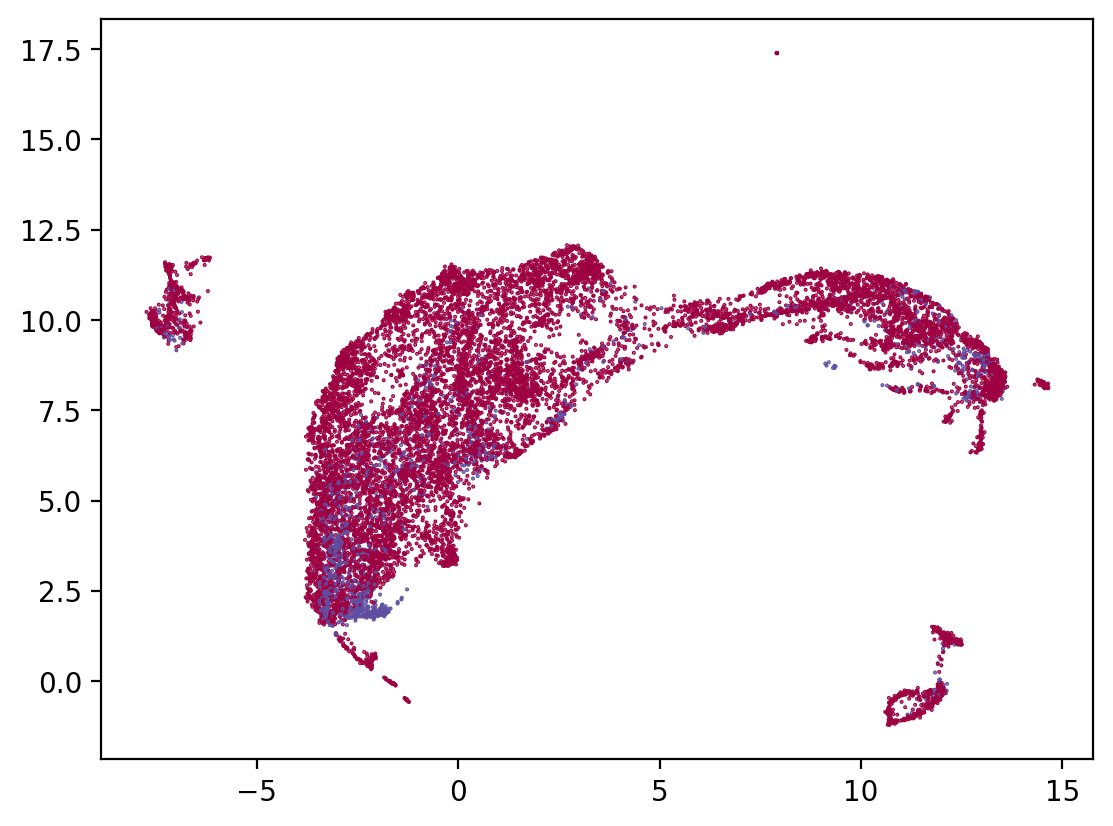

In [340]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=result.rain_error, s=0.2, cmap='Spectral')

In [334]:
labels = hdbscan.HDBSCAN(
    min_samples=2,
    min_cluster_size=200,
).fit_predict(clusterable_embedding)

In [255]:
labels

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

In [256]:
(
    adjusted_rand_score(result.error_state, labels),
    adjusted_mutual_info_score(result.error_state, labels)
)

(0.07717676861062367, 0.11564685185697154)

In [248]:
clustered = (labels >= 0)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


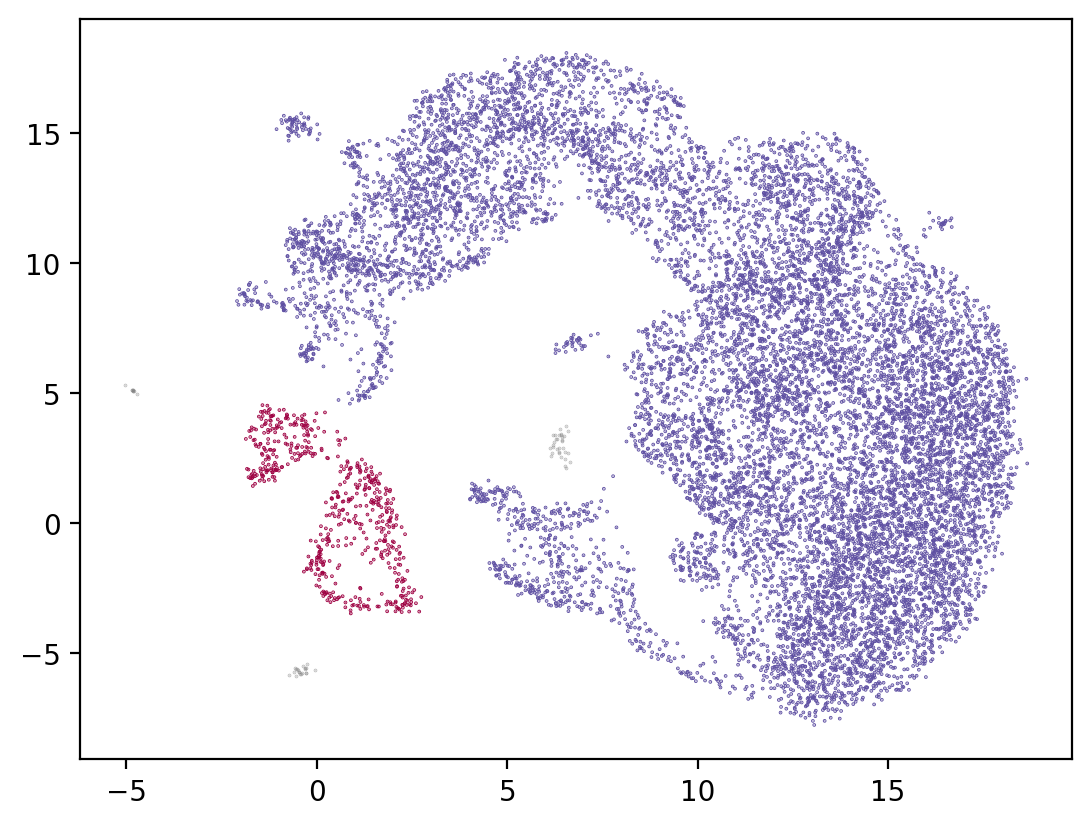

In [249]:
clustered = (labels >= 0)
plt.scatter(clusterable_embedding[~clustered, 0],
            clusterable_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(clusterable_embedding[clustered, 0],
            clusterable_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral');

In [250]:
(
    adjusted_rand_score(result.error_state[clustered], labels[clustered]),
    adjusted_mutual_info_score(result.error_state[clustered], labels[clustered])
)

(0.08544763836712643, 0.11637632272903657)

In [251]:
np.sum(clustered) / result.error_state.shape[0]

0.9955034645437122

In [310]:
pd.DataFrame(clusterable_embedding)

0         1         2          3
0       9.902392  6.970826 -0.545782  11.053509
1      10.088582  7.092882 -0.253834  10.852865
2      10.226300  6.852251 -0.586127  10.783575
3      10.505536  6.962620  0.153345  10.915830
4      10.673733  7.340327  1.025088  11.662005
...          ...       ...       ...        ...
13561   9.662311  5.537242 -2.135670  11.106663
13562   9.595751  5.696706 -2.045722  10.836298
13563   9.881739  5.635985 -1.685099  11.094943
13564   9.913066  5.594767 -1.756709  11.239765
13565   9.986932  5.586151 -1.552000  11.315626

[13566 rows x 4 columns]

In [314]:
kmeans_umap = cluster.KMeans(n_clusters=3, random_state=0).fit(clusterable_embedding)
print(kmeans_umap.cluster_centers_)
kmeans_umap_labels = kmeans_umap.predict(clusterable_embedding)

[[ 8.682328    7.4912176  -0.08386731  7.1761475 ]
 [11.1814995   6.9813128   2.817029   10.666915  ]
 [ 1.1519876   9.129681    1.8995025   9.728878  ]]


In [289]:
kmeans_umap_color = np.where(kmeans_umap_labels > 0, 'red', 'blue')
kmeans_umap_color

array(['blue', 'blue', 'blue', ..., 'red', 'red', 'blue'], dtype='<U4')

In [278]:
print('Accuracy: {}'.format(accuracy_score(result.error_state, kmeans_umap_labels)))
print('precision: {}'.format(precision_score(result.error_state, kmeans_umap_labels)))
print('recall: {}'.format(recall_score(result.error_state, kmeans_umap_labels)))

Accuracy: 0.3418104083738759


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

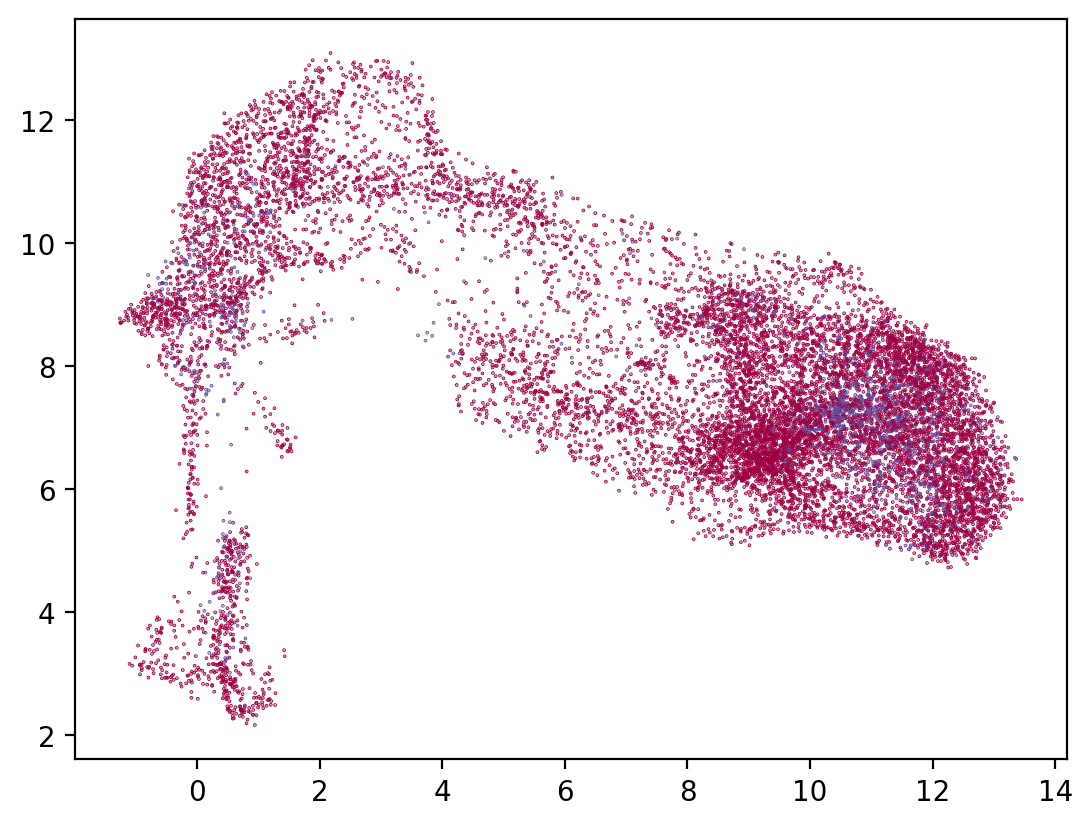

In [317]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], c=result.rain_error, s=0.1, cmap='Spectral')

In [292]:
from sklearn.metrics.pairwise import euclidean_distances

In [298]:
np.min(euclidean_distances(kmeans_umap.cluster_centers_,clusterable_embedding),0)

array([3.6185873, 3.2667556, 3.5389462, ..., 4.7750783, 4.941926 ,
       4.783587 ], dtype=float32)

In [294]:
kmeans_umap_labels

array([1, 1, 1, ..., 2, 2, 1])

# Dynamo


In [22]:
var = pd.DataFrame(index=df_X.columns.to_list())

In [23]:
X = df_X.copy()
X = X.to_numpy()

In [24]:
adata = ad.AnnData(X, obs=result, var=var, dtype='int32')
adata

c:\Users\004103\AppData\Local\Programs\Python\Python36\lib\site-packages\anndata\_core\anndata.py:119: ImplicitModificationWarning:

Transforming to str index.



AnnData object with n_obs × n_vars = 13566 × 96
    obs: 'station', 'DateTime', 'BatteryVoltage_max', 'BatteryVoltage_min', 'BatteryVoltage_mean', 'Humidity_max', 'Humidity_min', 'Humidity_mean', 'Rain_sum', 'Rain_max', 'Rain_min', 'Rain_mean', 'Temperature_max', 'Temperature_min', 'Temperature_mean', 'rain_stuck', 'batt_error', 'temp_error', 'humid_error', 'rain_error', 'error_state', 'error_label', 'error_color'

In [25]:
adata.layers["spliced"] = X
adata.layers["unspliced"] = X

In [26]:
adata = dyn.pp.recipe_monocle(adata, keep_filtered_cells=False, keep_filtered_genes=False)
adata.obsm['X_pca']

c:\Users\004103\AppData\Local\Programs\Python\Python36\lib\site-packages\dynamo\preprocessing\preprocess.py:1374: UserWarning:

only 96 genes passed basic filtering, but you requested 2000 genes for feature selection. Try lowering the gene selection stringency: {'min_expr_cells': 0, 'min_expr_avg': 0, 'max_expr_avg': inf, 'svr_gamma': None, 'winsorize': False, 'winsor_perc': (1, 99.5), 'sort_inverse': False}

c:\Users\004103\AppData\Local\Programs\Python\Python36\lib\site-packages\dynamo\preprocessing\utils.py:421: RuntimeWarning:

invalid value encountered in log1p

c:\Users\004103\AppData\Local\Programs\Python\Python36\lib\site-packages\dynamo\preprocessing\preprocess.py:1459: UserWarning:

Dynamo is not able to perform cell cycle staging for you automatically. 
Since dyn.pl.phase_diagram in dynamo by default color cells by its cell-cycle stage, 
you need to set color argument accordingly if confronting errors related to this.



array([[-4.03839937e+00,  1.80378678e-01,  1.43304964e+00, ...,
         2.65376799e-03, -2.66021834e-03,  4.60634181e-03],
       [-3.99416459e+00,  1.17857376e-01,  3.55938770e-01, ...,
        -2.39814754e-02, -2.62081088e-02, -6.69682135e-03],
       [-3.89150304e+00,  1.90517276e-01,  1.57570964e-01, ...,
        -1.83573188e-03,  2.25108488e-02, -1.22147983e-02],
       ...,
       [-4.38436286e+00,  4.34952698e-01,  6.65200443e-01, ...,
        -9.90647664e-03,  1.36927759e-02, -6.74770656e-03],
       [-4.29485454e+00,  4.22715571e-01,  6.10534189e-01, ...,
        -1.47551044e-02,  4.00501759e-02, -2.08030232e-02],
       [-4.33026093e+00,  3.01198678e-01,  5.38580347e-01, ...,
        -1.73209948e-02,  1.78153085e-02,  3.25832741e-02]])

In [27]:
adata = dyn.tl.dynamics(adata, model='stochastic', est_method='negbin')

estimating gamma: 100%|██████████| 35/35 [00:00<00:00, 91.40it/s]


In [356]:
result.error_color

0        blue
1        blue
2        blue
3        blue
4        blue
         ... 
13654    blue
13655    blue
13656    blue
13657    blue
13658    blue
Name: error_color, Length: 13566, dtype: object

In [405]:

start = time.time()
dyn.tl.reduceDimension(adata, reduction_method='umap', enforce=True, n_neighbors=200)
print('Duration: {} seconds'.format(time.time() - start))

Duration: 68.11362266540527 seconds


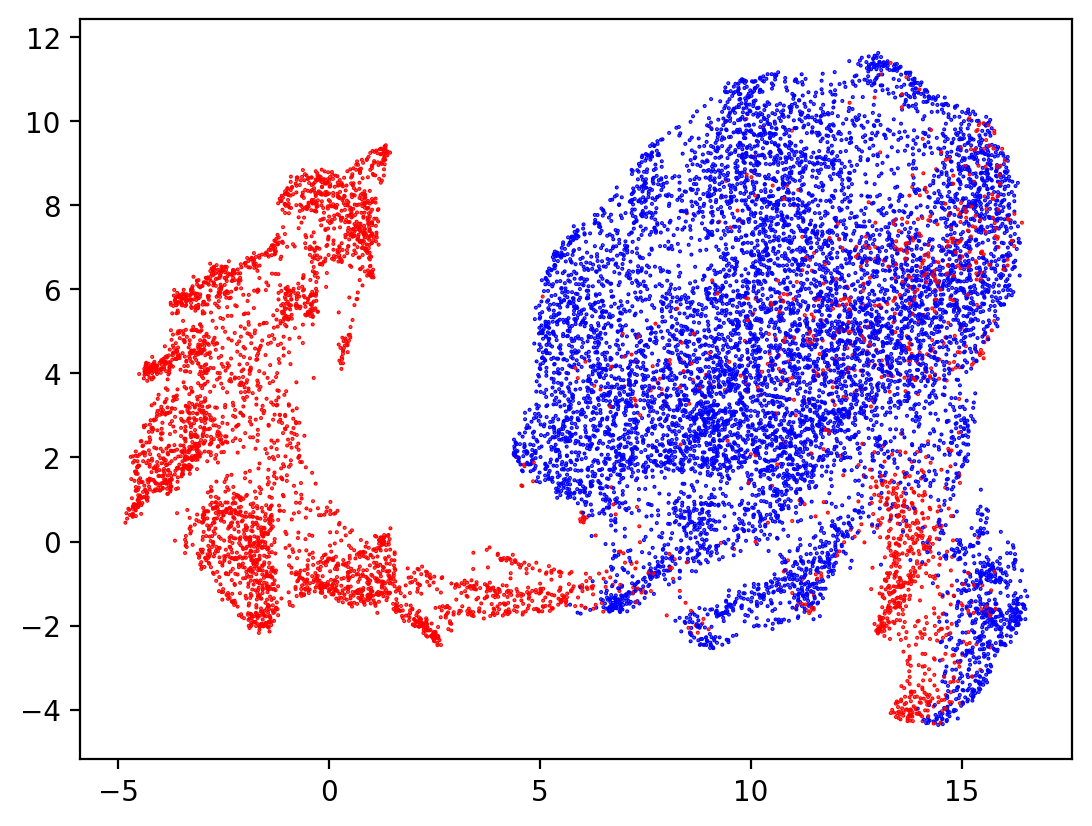

In [406]:
plt.scatter(adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1],
            c=result.error_color, s=0.2, cmap='Spectral')

In [40]:
dyn.tl.cell_velocities(adata, method='pearson', other_kernels_dict={'transform': 'sqrt'})

calculating transition matrix via pearson kernel with sqrt transform.: 100%|██████████| 13566/13566 [00:04<00:00, 2852.41it/s]
projecting velocity vector to low dimensional embedding...: 100%|██████████| 13566/13566 [00:02<00:00, 5026.81it/s]


AnnData object with n_obs × n_vars = 13566 × 96
    obs: 'station', 'DateTime', 'BatteryVoltage_max', 'BatteryVoltage_min', 'BatteryVoltage_mean', 'Humidity_max', 'Humidity_min', 'Humidity_mean', 'Rain_sum', 'Rain_max', 'Rain_min', 'Rain_mean', 'Temperature_max', 'Temperature_min', 'Temperature_mean', 'rain_stuck', 'batt_error', 'temp_error', 'humid_error', 'rain_error', 'error_state', 'error_label', 'error_color', 'nGenes', 'nCounts', 'pMito', 'use_for_pca', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'Size_Factor', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'ntr'
    var: 'pass_basic_filter', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp_norm_method', 'PCs', 'explained_variance_ratio_', 'pca_fit', 'feature_selection', 'dynamics', 'neighbors', 'umap_fit

<Figure size 600x400 with 0 Axes>

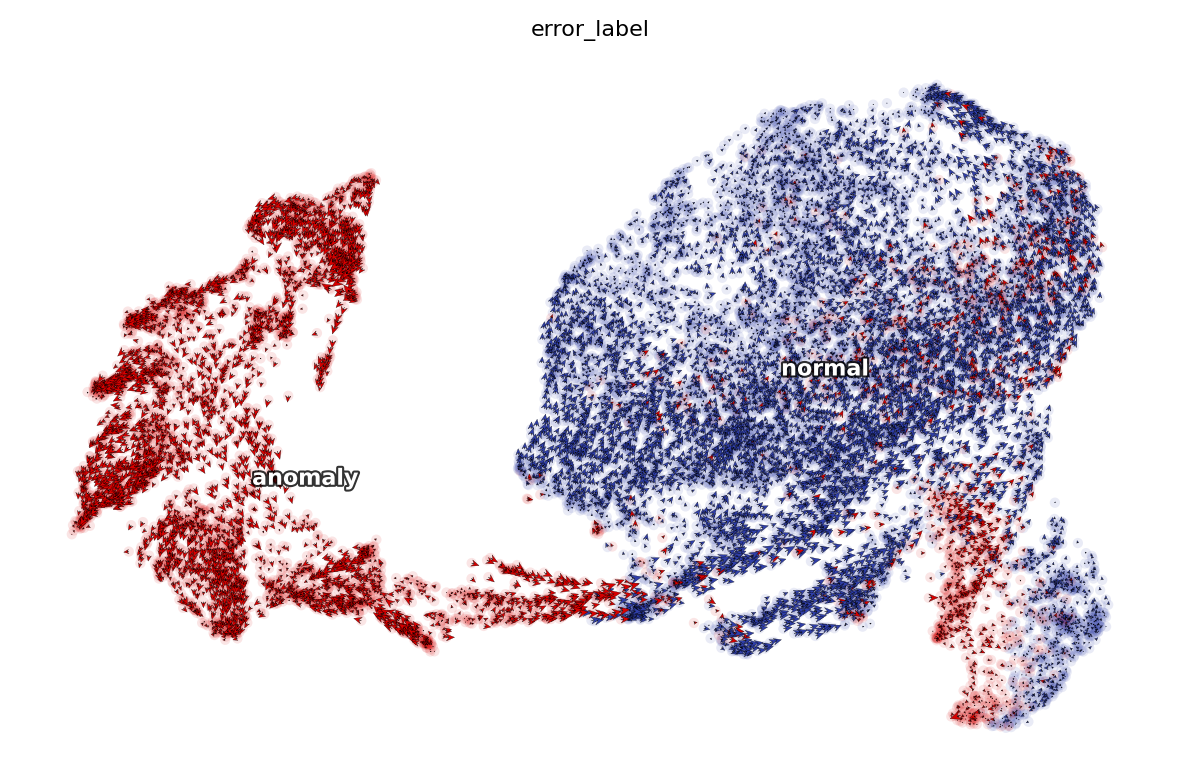

In [41]:
dyn.pl.cell_wise_vectors(adata, color=['error_label'], basis='umap', show_legend='on data', quiver_length=6, quiver_size=6, pointsize=0.1, show_arrowed_spines=False)

In [42]:
dyn.vf.VectorField(adata, basis='umap', pot_curl_div=True, verbose=3) # , M=1000, MaxIter=1000
dyn.pl.streamline_plot(adata, color=['error_label'], basis='umap', show_legend='on data', show_arrowed_spines=True)

Sampling control points based on data velocity magnitude...
Time elapsed for 'con_K': 0.0050 s
Time elapsed for 'con_K': 0.1352 s
Time elapsed for 'con_K': 0.0300 s

iterate: 0, gamma: 0.900, energy change rate: 1.000e+00, sigma2=1.827e-01
Time elapsed for computing lhs and rhs: 0.252646 s
Time elapsed for 'lstsq_solver': 0.0200 s

iterate: 1, gamma: 0.950, energy change rate: 7.391e-01, sigma2=2.740e-02
Time elapsed for computing lhs and rhs: 0.253688 s
Time elapsed for 'lstsq_solver': 0.0177 s

iterate: 2, gamma: 0.950, energy change rate: 1.097e+00, sigma2=3.493e-01
Time elapsed for computing lhs and rhs: 0.236595 s
Time elapsed for 'lstsq_solver': 0.0145 s

iterate: 3, gamma: 0.914, energy change rate: 1.263e+01, sigma2=2.875e-02
Time elapsed for computing lhs and rhs: 0.229227 s
Time elapsed for 'lstsq_solver': 0.0179 s

iterate: 4, gamma: 0.950, energy change rate: 1.096e-01, sigma2=2.401e-02
Time elapsed for computing lhs and rhs: 0.231209 s
Time elapsed for 'lstsq_solver': 0.02

Constructing diffusion graph from reconstructed vector field: 5000it [02:07, 39.34it/s]


LinAlgError: SVD did not converge

### KMEAN Eval

In [415]:
kmeans_labels = cluster.KMeans(n_clusters=2).fit_predict(adata.obsm['X_umap'])
kmeans_labels

array([0, 0, 0, ..., 0, 0, 0])

In [416]:
kmeans_umap_color = np.where(kmeans_labels > 0, 'red', 'blue')
kmeans_umap_color

array(['blue', 'blue', 'blue', ..., 'blue', 'blue', 'blue'], dtype='<U4')

In [417]:
result.error_state.to_numpy()

array([0, 0, 0, ..., 0, 0, 0])

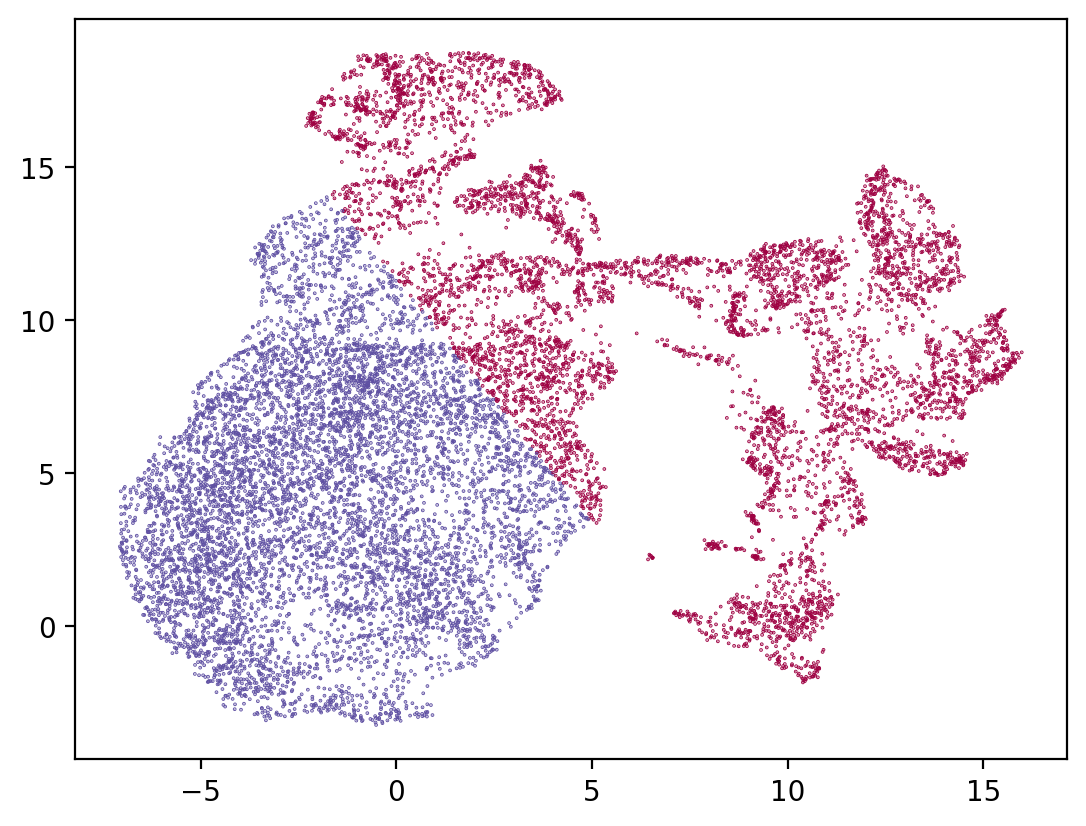

In [404]:
plt.scatter(adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1], c=kmeans_labels, s=0.1, cmap='Spectral')


In [362]:
(
    adjusted_rand_score(result.error_state, kmeans_labels),
    adjusted_mutual_info_score(result.error_state, kmeans_labels)
)

(0.6599346870295584, 0.5680008579708825)

In [56]:
kmeans_labels

array([0, 0, 0, ..., 0, 0, 0])

In [57]:
print('Accuracy: {}'.format(accuracy_score(result.error_state, kmeans_labels)))
print('precision: {}'.format(precision_score(result.error_state, kmeans_labels)))
print('recall: {}'.format(recall_score(result.error_state, kmeans_labels)))

Accuracy: 0.8985699542975085
precision: 0.958765778401122
recall: 0.7355282978265547


# Autoencoder

In [170]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import plot_model
## Standardizing the data
ae_X = df_X.copy()

# ae_X = StandardScaler().fit_transform(ae_X)
# ae_X

min_max_scaler = MinMaxScaler()
ae_X = min_max_scaler.fit_transform(ae_X).astype(np.float32)
ae_X.shape

(13566, 96)

In [171]:
inputs = Input(shape=(ae_X.shape[1],))

en1 = layers.Dense(ae_X.shape[1] // 2, activation='tanh')
en2 = layers.Dense(ae_X.shape[1] // 4, activation='tanh')
en3 = layers.Dense(ae_X.shape[1] // 6, activation='tanh')
en4 = layers.Dense(ae_X.shape[1] // 8, activation='tanh')
en5 = layers.Dense(ae_X.shape[1] // 12, activation='tanh')
en6 = layers.Dense(ae_X.shape[1] // 24, activation='tanh')
en7 = layers.Dense(ae_X.shape[1] // 48, activation='tanh')

de7 = layers.Dense(ae_X.shape[1] // 24, activation='tanh')
de6 = layers.Dense(ae_X.shape[1] // 12, activation='tanh')
de5 = layers.Dense(ae_X.shape[1] // 8, activation='tanh')
de4 = layers.Dense(ae_X.shape[1] // 6, activation='tanh')
de3 = layers.Dense(ae_X.shape[1] // 4, activation='tanh')
de2 = layers.Dense(ae_X.shape[1] // 2, activation='tanh')
de1 = layers.Dense(ae_X.shape[1], activation='tanh')

outputs = de1(de2(de3(de4(de5(de6(de7(en7(en6(en5(en4(en3(en2(en1(inputs))))))))))))))
model = Model(inputs, outputs)

In [172]:
# model.compile(loss=losses.MeanSquaredError(), optimizer=optimizers.SGD(lr=0.1))
model.compile(loss=losses.MeanSquaredError(), optimizer='adam')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96)]              0         
_________________________________________________________________
dense_14 (Dense)             (None, 48)                4656      
_________________________________________________________________
dense_15 (Dense)             (None, 24)                1176      
_________________________________________________________________
dense_16 (Dense)             (None, 16)                400       
_________________________________________________________________
dense_17 (Dense)             (None, 12)                204       
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 36  

In [173]:
# from tensorflow.keras.utils import plot_model

# plot_model(model, 'autoencoder_no_compress.png', show_shapes=True)

In [174]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
start = time.time()
embeding  = model.fit(ae_X, ae_X, epochs=300, shuffle=True, callbacks=[callback])
print('Duration: {} seconds'.format(time.time() - start))

Epoch 1/300
424/424 [==============================] - 1s 1ms/step - loss: 0.1107
Epoch 2/300
424/424 [==============================] - 0s 1ms/step - loss: 0.0084
Epoch 3/300
424/424 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 4/300
424/424 [==============================] - 1s 1ms/step - loss: 0.0024
Epoch 5/300
424/424 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 6/300
424/424 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 7/300
424/424 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 8/300
424/424 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 9/300
424/424 [==============================] - ETA: 0s - loss: 0.001 - 0s 1ms/step - loss: 0.0016
Epoch 10/300
424/424 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 11/300
424/424 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 12/300
424/424 [==============================] - 0s 1ms/step - lo

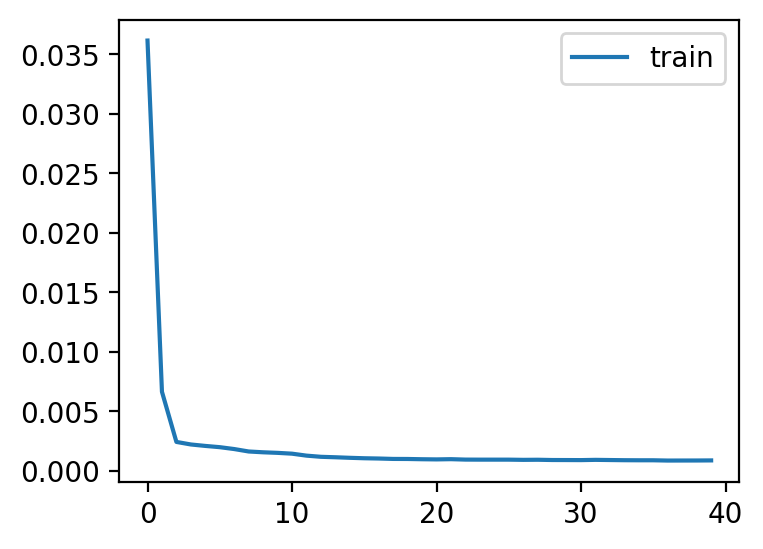

In [175]:
# plot training history
fig = plt.subplots(figsize=(4,3))
plt.plot(embeding.history['loss'], label='train')
plt.legend()
plt.show()

In [176]:
start = time.time()
XEn =en7(en6(en5(en4(en3(en2(en1(ae_X))))))).numpy()
print('Duration: {} seconds'.format(time.time() - start))
print(XEn.shape)

Duration: 0.030004501342773438 seconds
(13566, 2)


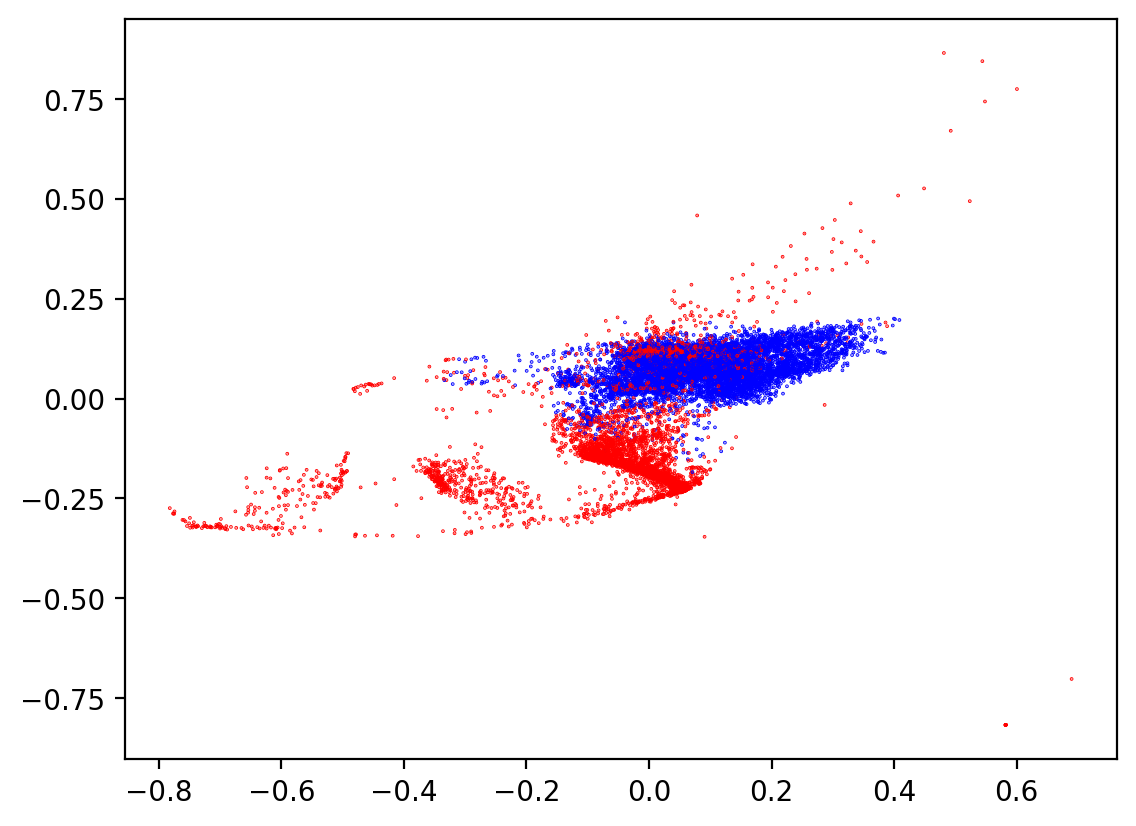

In [177]:
plt.scatter(XEn[:, 0], XEn[:, 1], c=result.error_color, s=0.1, cmap='Spectral')

In [407]:
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(XEn)
labels

array([ 1,  1,  1, ..., -1, -1,  1], dtype=int64)

In [408]:
(
    adjusted_rand_score(result.error_state, labels),
    adjusted_mutual_info_score(result.error_state, labels)
)

(0.5186740887809504, 0.395765998058088)

In [202]:
clustered = (labels >= 0)

In [203]:
(
    adjusted_rand_score(result.error_state[clustered], labels[clustered]),
    adjusted_mutual_info_score(result.error_state[clustered], labels[clustered])
)

(0.08476089040101532, 0.11349739200010847)

In [204]:
np.sum(clustered) / result.error_state.shape[0]

0.9952823234556981

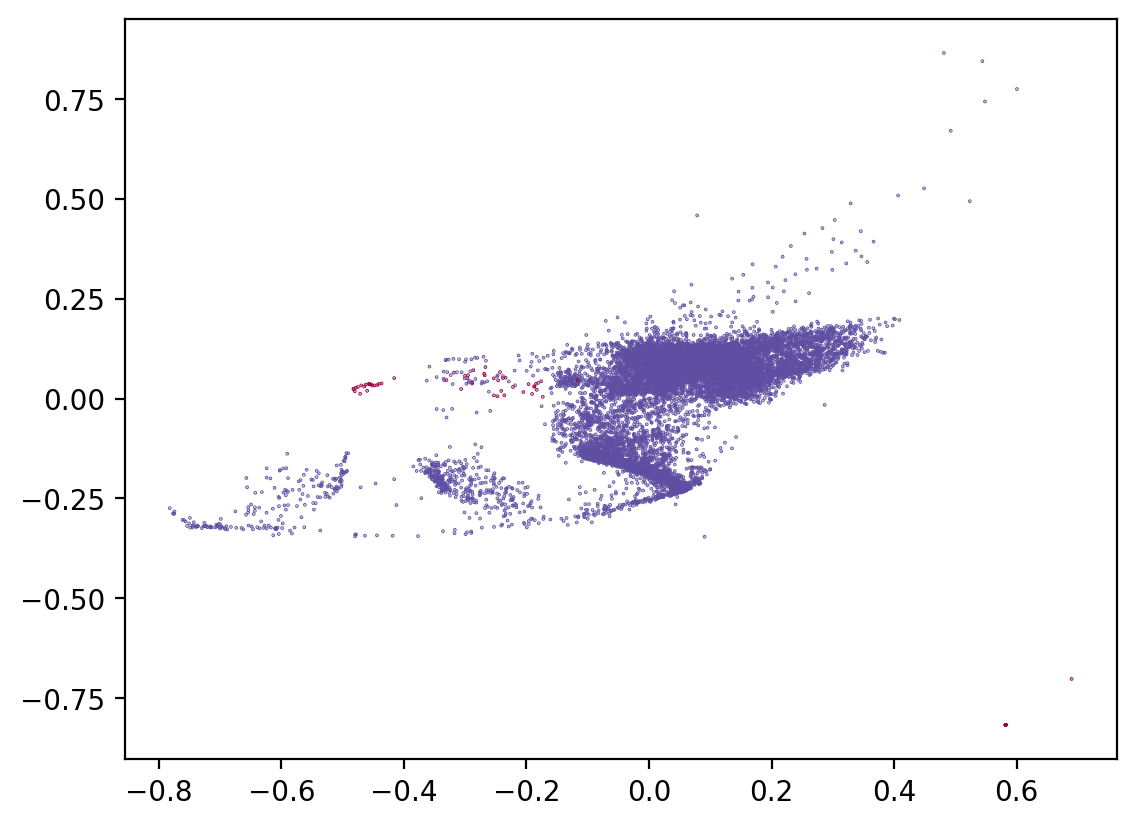

In [409]:

plt.scatter(XEn[:,0], XEn[:,1], c=clustered, s=0.1, cmap='Spectral')


## K-Mean Eval

In [183]:
kmeans_AE_labels = cluster.KMeans(n_clusters=2).fit_predict(XEn)
kmeans_AE_labels

array([0, 0, 0, ..., 0, 0, 0])

In [323]:
(
    adjusted_rand_score(result.error_state, kmeans_AE_labels),
    adjusted_mutual_info_score(result.error_state, kmeans_AE_labels)
)

(0.599996918525763, 0.47523636077489967)

In [184]:
print('Accuracy: {}'.format(accuracy_score(result.error_state, kmeans_AE_labels)))
print('precision: {}'.format(precision_score(result.error_state, kmeans_AE_labels)))
print('recall: {}'.format(recall_score(result.error_state, kmeans_AE_labels)))

Accuracy: 0.8895768833849329
precision: 0.9015557255802091
recall: 0.7607058317193889


In [185]:
kmeans_AE_color = np.where(kmeans_AE_labels > 0, 'red', 'blue')
kmeans_AE_color

array(['blue', 'blue', 'blue', ..., 'blue', 'blue', 'blue'], dtype='<U4')

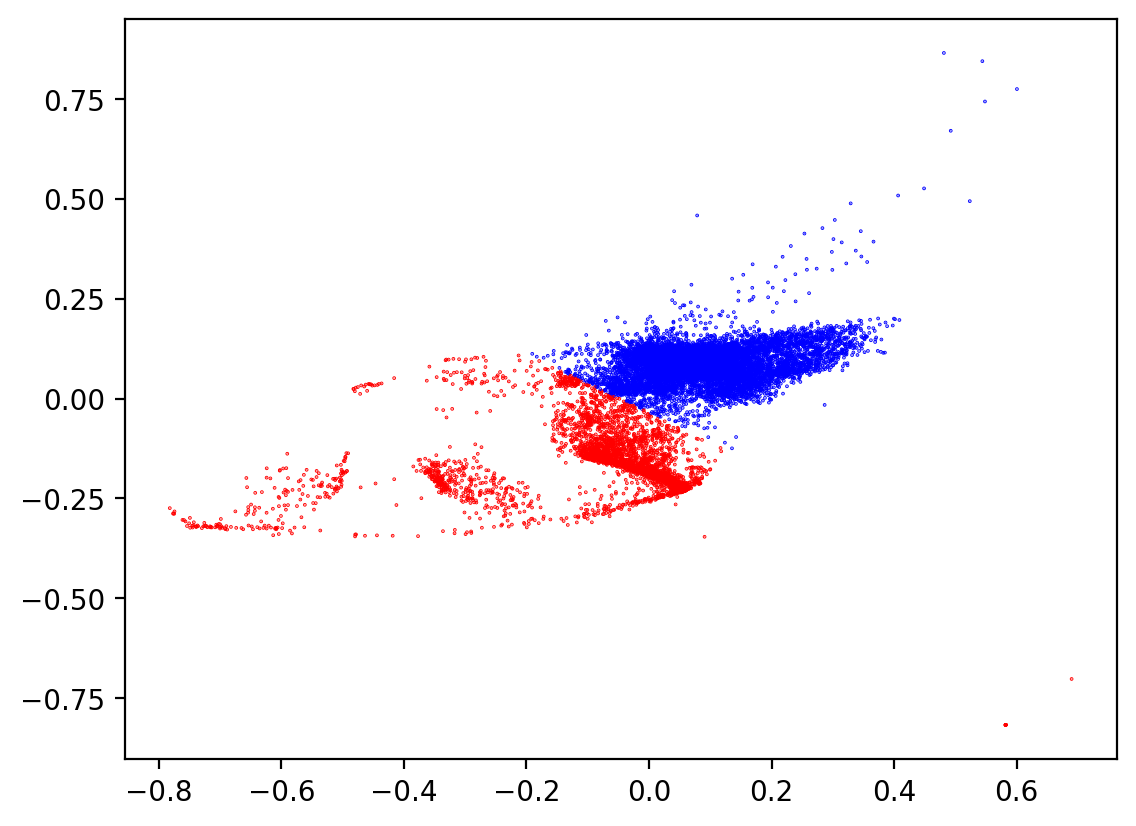

In [186]:
plt.scatter(XEn[:, 0], XEn[:, 1], c=kmeans_AE_color, s=0.1, cmap='Spectral')

# t-SNE

In [82]:
x_tsne = df_X.copy()
x_tsne = StandardScaler().fit_transform(x_tsne)

In [84]:
start = time.time()
pca_30 = PCA(n_components=30)
# pca_result_30 = pca_30.fit_transform(x_tsne)
# tsne = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=400).fit_transform(pca_result_30)
tsne = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=400).fit_transform(x_tsne)
print('Duration: {} seconds'.format(time.time() - start))

Duration: 33.39903402328491 seconds


In [102]:
tsne

array([[-15.762702 ,   3.0686095],
       [-14.824492 ,   3.5144694],
       [-14.581597 ,   3.6907978],
       ...,
       [-17.184849 ,   6.219506 ],
       [-17.07352  ,   6.315603 ],
       [-17.044636 ,   6.1009235]], dtype=float32)

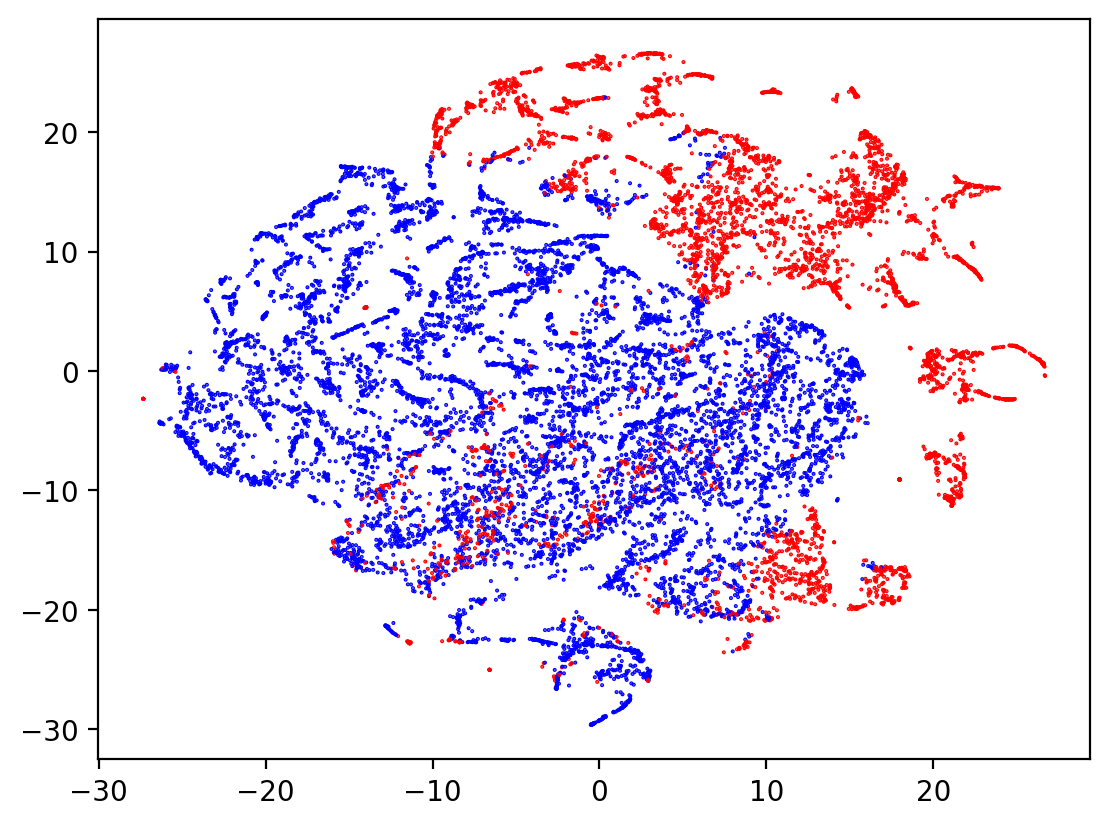

In [85]:
plt.scatter(tsne[:, 0], tsne[:, 1],
            c=result.error_color, s=0.2, cmap='Spectral')

In [87]:
labels = hdbscan.HDBSCAN(
    gen_min_span_tree=True,
    min_cluster_size=200
).fit_predict(tsne)

In [88]:
labels

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

In [89]:
(
    adjusted_rand_score(result.error_state, labels),
    adjusted_mutual_info_score(result.error_state, labels)
)

(0.14534095467718933, 0.0955212706459977)

In [90]:
clustered = (labels >= 0)

In [91]:
(
    adjusted_rand_score(result.error_state[clustered], labels[clustered]),
    adjusted_mutual_info_score(result.error_state[clustered], labels[clustered])
)

(0.03894961216551249, 0.07201773852757959)

In [92]:
np.sum(clustered) / result.error_state.shape[0]

0.7739200943535309

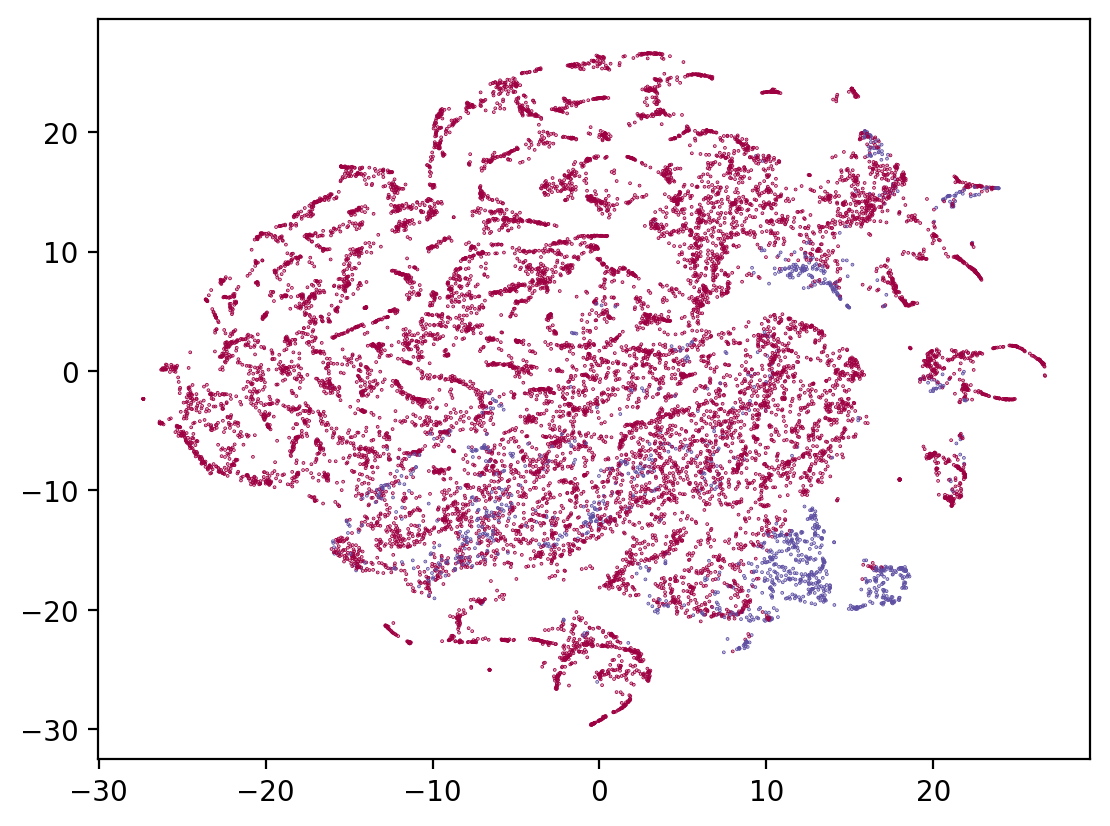

In [94]:
plt.scatter(tsne[:, 0], tsne[:, 1], c=result.rain_error, s=0.1, cmap='Spectral')

In [330]:
kmeans_tsne_labels = cluster.KMeans(n_clusters=2).fit_predict(tsne)
kmeans_tsne_labels

array([0, 0, 0, ..., 0, 0, 0])

In [331]:
(
    adjusted_rand_score(result.error_state, kmeans_tsne_labels),
    adjusted_mutual_info_score(result.error_state, kmeans_tsne_labels)
)

(0.19605982626655125, 0.15108996203178754)

In [136]:
kmeans_tsne_color = np.where(kmeans_tsne_labels > 0, 'red', 'blue')
kmeans_tsne_color

array(['blue', 'blue', 'blue', ..., 'blue', 'blue', 'blue'], dtype='<U4')

In [137]:
print('Accuracy: {}'.format(accuracy_score(result.error_state, kmeans_tsne_labels)))
print('precision: {}'.format(precision_score(result.error_state, kmeans_tsne_labels)))
print('recall: {}'.format(recall_score(result.error_state, kmeans_tsne_labels)))

Accuracy: 0.7218045112781954
precision: 0.5701655682366179
recall: 0.7632881428878846


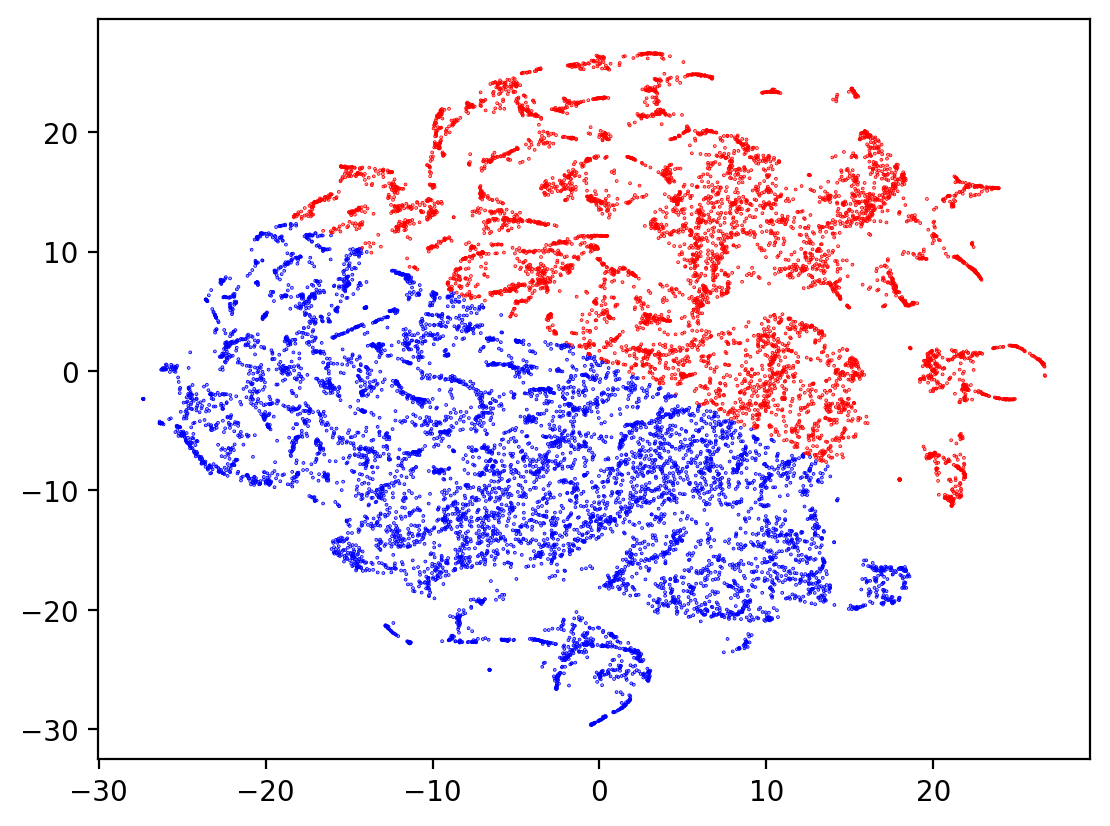

In [138]:
plt.scatter(tsne[:, 0], tsne[:, 1], c=kmeans_tsne_color, s=0.1, cmap='Spectral')

In [376]:
from bokeh.layouts import column
name = result.error_label.tolist()
source1 = ColumnDataSource(dict(
    x=adata.obsm['X_umap'][:,0],
    y=adata.obsm['X_umap'][:,1],
    color=result.error_color,
    label=name
))
p1 = figure(plot_width=450, plot_height=400, title="1hour sampling", x_axis_label = "UMAP-0", y_axis_label ="UMAP-1", x_range=(-8, 20), y_range=(-8, 20))
p1.circle(x='x', y='y', color='color', fill_alpha=0.8, size=2,legend_field='label', source=source1)

source2 = ColumnDataSource(dict(
    x=XEn[:,0],
    y=XEn[:,1],
    color=result.error_color,
    label=name
))
p2 = figure(plot_width=450, plot_height=400, title="1hour sampling", x_axis_label = "AE-0", y_axis_label ="AE-1")
p2.circle(x='x', y='y', color='color', fill_alpha=0.8, size=2,legend_field='label', source=source2)

source3 = ColumnDataSource(dict(
    x=tsne[:,0],
    y=tsne[:,1],
    color=result.error_color,
    label=name
))
p3 = figure(plot_width=450, plot_height=400, title="1hour sampling", x_axis_label = "tSNE-0", y_axis_label ="tSNE-1")
p3.circle(x='x', y='y', color='color', fill_alpha=0.8, size=2,legend_field='label', source=source3)



grid = gridplot([[p1, p2], [p3, None]])

show(grid)

In [103]:
from scipy.stats import ttest_ind

In [115]:

ttest_ind(kmeans_tsne_labels, kmeans_labels).pvalue

2.079154110658445e-252

In [413]:
result['kmeans_AE_labels'] = kmeans_AE_labels
result['kmeans_tsne_labels'] = kmeans_tsne_labels
result['kmeans_umap_labels'] = kmeans_labels
result

station   DateTime  BatteryVoltage_max  BatteryVoltage_min  \
0      CM-LS-002 2014-01-01           13.858333           12.700000   
1      CM-LS-002 2014-01-02           13.900000           12.700000   
2      CM-LS-002 2014-01-03           14.083333           12.700000   
3      CM-LS-002 2014-01-04           14.308333           12.700000   
4      CM-LS-002 2014-01-05           13.833333           12.700000   
...          ...        ...                 ...                 ...   
13654  CM-LS-241 2019-12-22           13.533333           12.891667   
13655  CM-LS-241 2019-12-23           13.525000           12.841667   
13656  CM-LS-241 2019-12-24           13.516667           12.825000   
13657  CM-LS-241 2019-12-25           13.516667           12.816667   
13658  CM-LS-241 2019-12-26           13.516667           12.825000   

       BatteryVoltage_mean  Humidity_max  Humidity_min  Humidity_mean  \
0                13.108681     87.858333     48.591667      77.835764   
1                13.141667     87.875000     54.600000      78.327778   
2                13.171528     87.700000     49.841667      77.736806   
3                13.183681     87.850000     57.308333      78.577778   
4                13.118750     88.683333     61.358333      81.646875   
...                    ...           ...           ...            ...   
13654            13.194097     98.625000     36.616667      78.778819   
13655            13.182292     98.708333     35.391667      77.961458   
13656            13.181250     98.825000     40.108333      79.918403   
13657            13.174306     98.825000     41.200000      80.504514   
13658            13.172569     99.033333     43.908333      81.504514   

       Rain_sum  Rain_max  ...  batt_error  temp_error  humid_error  \
0          55.0       2.4  ...           0           0            0   
1          42.0       2.4  ...           0           0            0   
2          47.8       2.4  ...           0           0            0   
3          38.4       2.4  ...           0           0            0   
4          44.8       2.4  ...           0           0            0   
...         ...       ...  ...         ...         ...          ...   
13654       0.2       0.2  ...           0           0            0   
13655      41.0       2.4  ...           0           0            0   
13656       0.2       0.2  ...           0           0            0   
13657      43.2       2.4  ...           0           0            0   
13658       0.2       0.2  ...           0           0            0   

       rain_error  error_state  error_label  error_color  kmeans_AE_labels  \
0               0            0       normal         blue                 0   
1               0            0       normal         blue                 0   
2               0            0       normal         blue                 0   
3               0            0       normal         blue                 0   
4               0            0       normal         blue                 0   
...           ...          ...          ...          ...               ...   
13654           0            0       normal         blue                 0   
13655           0            0       normal         blue                 0   
13656           0            0       normal         blue                 0   
13657           0            0       normal         blue                 0   
13658           0            0       normal         blue                 0   

       kmeans_tsne_labels  kmeans_umap_labels  
0                       0                   0  
1                       0                   0  
2                       0                   0  
3                       0                   0  
4                       0                   0  
...                   ...                 ...  
13654                   0                   0  
13655                   0                   0  
13656                   0                   0  
13657    

In [414]:
result.to_csv("cluster_data/result_1hr.csv", header=True, index=False)

In [375]:
from bokeh.layouts import column
name = result.error_label.tolist()
source1 = ColumnDataSource(dict(
    x=adata.obsm['X_umap'][:,0],
    y=adata.obsm['X_umap'][:,1],
    color=kmeans_umap_color,
    label=kmeans_labels
))
p1 = figure(plot_width=450, plot_height=400, title="1hour sampling", x_axis_label = "UMAP-0", y_axis_label ="UMAP-1", x_range=(-8, 20), y_range=(-8, 20))
p1.circle(x='x', y='y', color='color', fill_alpha=0.8, size=2,legend_field='label', source=source1)
p1.legend.title = 'k-means'

source2 = ColumnDataSource(dict(
    x=XEn[:,0],
    y=XEn[:,1],
    color=kmeans_AE_color,
    label=kmeans_AE_labels
))
p2 = figure(plot_width=450, plot_height=400, title="1hour sampling", x_axis_label = "AE-0", y_axis_label ="AE-1")
p2.circle(x='x', y='y', color='color', fill_alpha=0.8, size=2,legend_field='label', source=source2)
p2.legend.title = 'k-means'

source3 = ColumnDataSource(dict(
    x=tsne[:,0],
    y=tsne[:,1],
    color=kmeans_tsne_color,
    label=kmeans_tsne_labels
))
p3 = figure(plot_width=450, plot_height=400, title="1hour sampling", x_axis_label = "tSNE-0", y_axis_label ="tSNE-1")
p3.circle(x='x', y='y', color='color', fill_alpha=0.8, size=2,legend_field='label', source=source3)
p3.legend.title = 'k-means'



grid = gridplot([[p1, p2], [p3, None]])

show(grid)